# CTCF
[autosomal dominant intellectual developmental disorder-21 (MRD21)](https://omim.org/entry/615502) is caused by heterozygous mutation in the CTCF gene.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.5.1.dev0


# CTCF
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for CTCF.

In [2]:
gene_symbol = 'CTCF'
mane_tx_id = 'NM_006565.4'
mane_protein_id = 'NP_006556.1' # transcriptional repressor CTCF isoform 1"

In [9]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.20") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
len(phenopackets)


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

validation.summarize()

Individuals Processed: 100%|██████████| 46/46 [01:24<00:00,  1.84s/individuals]
Validated under permissive policy
No errors or warnings were found


In [10]:
from gpsea.view import CohortViewable

viewer = CohortViewable(hpo=hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Intellectual disability,HP:0001249,46
Global developmental delay,HP:0001263,46
Feeding difficulties,HP:0011968,31
Delayed speech and language development,HP:0000750,31
Failure to thrive,HP:0001508,22
Delayed ability to walk,HP:0031936,22
Hypotonia,HP:0001252,19
Microcephaly,HP:0000252,18
Recurrent infections,HP:0002719,18
Thin upper lip vermilion,HP:0000219,13


<Axes: title={'center': 'Transcriptional repressor CTCF\ntranscript: NM_006565.4, protein: NP_006556.1'}>

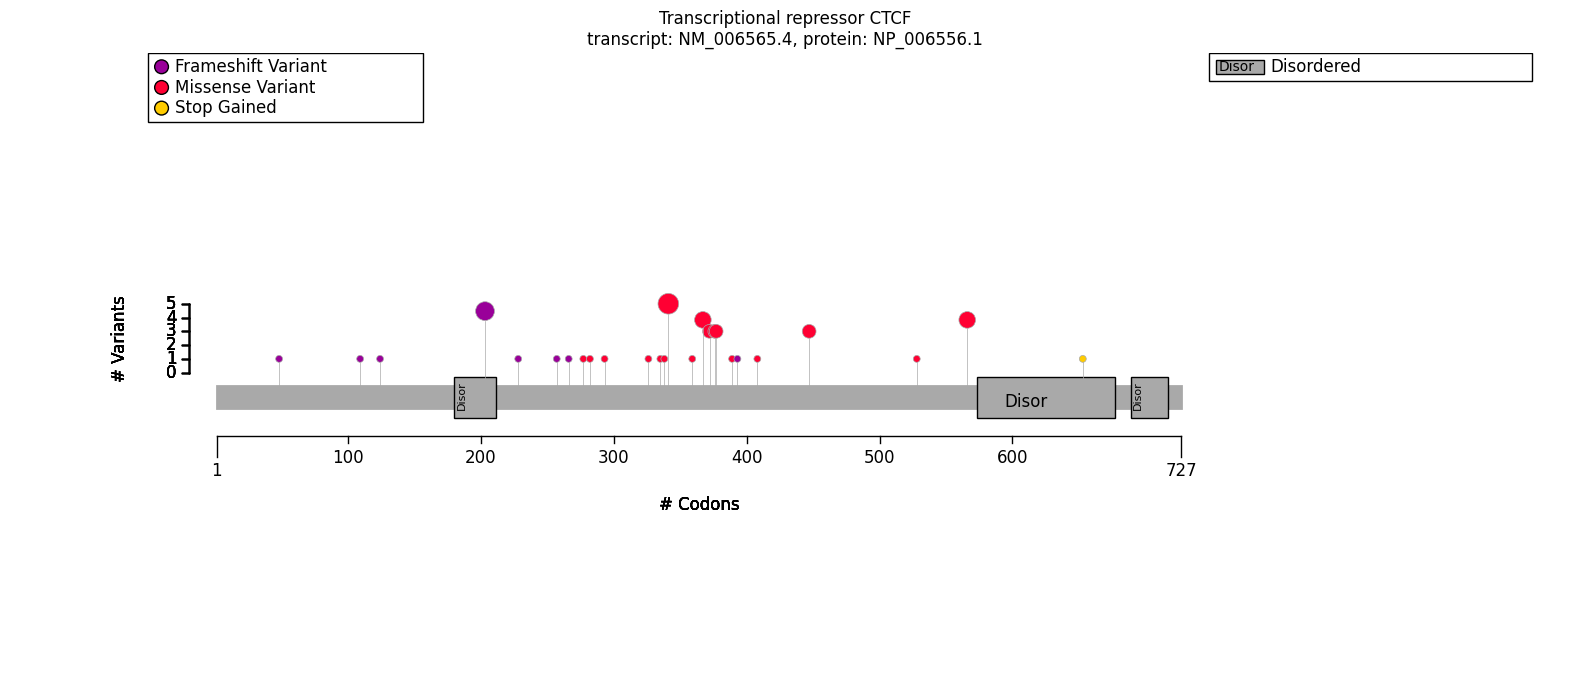

In [11]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService, configure_default_protein_metadata_service

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id) 
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)
from gpsea.view import ProteinVisualizable, ProteinVisualizer

pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)
drawer = ProteinVisualizer()
drawer.draw_fig(pvis=pvis)

In [16]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
    missing_implies_excluded=False,
    min_n_of_patients_with_term=2,
)
len(pheno_predicates)
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(
    hpo=hpo,
    term_frequency_threshold=0.1,
)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05
from gpsea.analysis.pcats.stats import FisherExactTest

count_statistic = FisherExactTest()
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
     mtc_alpha=mtc_alpha,
)

In [17]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)


gt_predicate = monoallelic_predicate(a_predicate=missense, b_predicate=~missense, names=("missense", "other"))
gt_predicate.display_question()

'Allele group: missense, other'

In [19]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.1,70
HMF03,Skipping term because of a child term with the same individual counts,8
HMF08,Skipping general term,51
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.25,101


In [20]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                           missense         other          \
                                          Count Percent Count Percent   
Narrow mouth [HP:0000160]                  1/29      3%  5/17     29%   
Mandibular prognathia [HP:0000303]         1/29      3%  4/17     24%   
Hearing impairment [HP:0000365]            9/26     35%  1/16      6%   
Camptodactyly [HP:0012385]                 0/29      0%  2/17     12%   
Macrotia [HP:0000400]                      0/29      0%  2/17     12%   
...                                         ...     ...   ...     ...   
Autistic behavior [HP:0000729]             5/29     17%  3/17     18%   
Atypical behavior [HP:0000708]              7/7    100%   6/6    100%   
Abnormal pinna morphology [HP:0000377]      5/5    100%   7/7    100%   
Epicanthus [HP:0000286]                    4/29     14%  3/17     18%   
Sleep abnormality [HP:0002360]             6/20     30%  3/11     27%   

Allele group                                                         
                                       Corrected p values  p values  
Narrow mouth [HP:0000160]                             1.0  0.020480  
Mandibular prognathia [HP:0000303]                    1.0  0.054866  
Hearing impairment [HP:0000365]                       1.0  0.060850  
Camptodactyly [HP:0012385]                            1.0  0.131401  
Macrotia [HP:0000400]                                 1.0  0.131401  
...                                                   ...       ...  
Autistic behavior [HP:0000729]                        1.0  1.000000  
Atypical behavior [HP:0000708]                        1.0  1.000000  
Abnormal pinna morphology [HP:0000377]                1.0  1.000000  
Epicanthus [HP:0000286]                               1.0  1.000000  
Sleep abnormality [HP:0002360]                        1.0  1.000000  

[62 rows x 6 columns]